In [1]:
import kagglehub
import os
import shutil
import librosa
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import sys

In [2]:
import shutil
import os

# Download and print actual paths
ravdess_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Ravdess Path:", ravdess_path)

cremad_path = kagglehub.dataset_download("ejlok1/cremad")
print("CremaD Path:", cremad_path)

tess_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("TESS Path:", tess_path)

savee_path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
print("Savee Path:", savee_path)

# Create destination folder if it doesn't exist
os.makedirs("/content/datasets", exist_ok=True)

# Move each dataset to /content/datasets
shutil.copytree(ravdess_path, "/content/datasets/ravdess", dirs_exist_ok=True)
shutil.copytree(cremad_path, "/content/datasets/cremad", dirs_exist_ok=True)
shutil.copytree(tess_path, "/content/datasets/tess", dirs_exist_ok=True)
shutil.copytree(savee_path, "/content/datasets/savee", dirs_exist_ok=True)

print("All datasets moved to /content/datasets")


Ravdess Path: /kaggle/input/ravdess-emotional-speech-audio
CremaD Path: /kaggle/input/cremad
TESS Path: /kaggle/input/toronto-emotional-speech-set-tess
Savee Path: /kaggle/input/surrey-audiovisual-expressed-emotion-savee
All datasets moved to /content/datasets


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

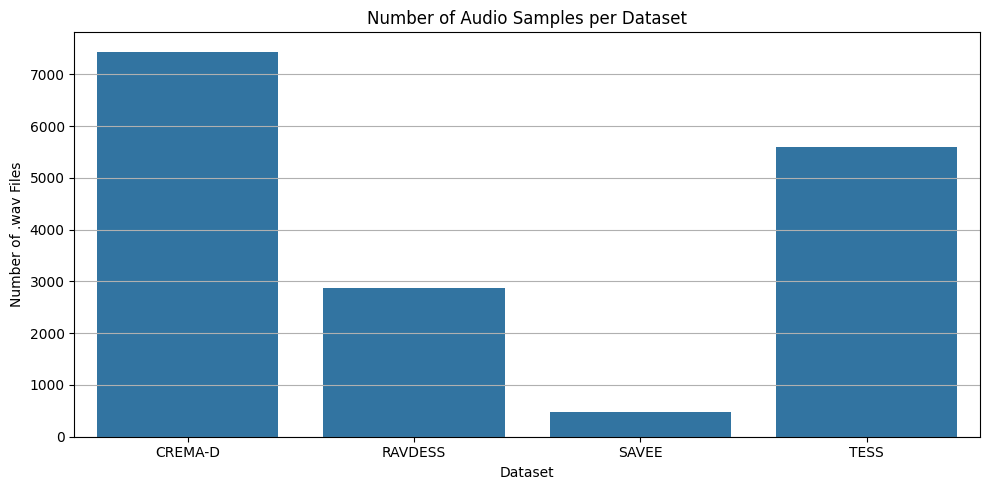

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to count .wav files recursively
def count_wav_files(path):
    count = 0
    for root, _, files in os.walk(path):
        count += sum(1 for f in files if f.endswith(".wav"))
    return count

# ✅ Correct dataset paths based on previous copy structure
cremad_path = "/content/datasets/cremad"
ravdess_path = "/content/datasets/ravdess"
savee_path = "/content/datasets/savee"
tess_path = "/content/datasets/tess"

# Count .wav files in each dataset
data_sizes = {
    "CREMA-D": count_wav_files(cremad_path),
    "RAVDESS": count_wav_files(ravdess_path),
    "SAVEE": count_wav_files(savee_path),
    "TESS": count_wav_files(tess_path),
}

# ✅ Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=list(data_sizes.keys()), y=list(data_sizes.values()))
plt.title("Number of Audio Samples per Dataset")
plt.ylabel("Number of .wav Files")
plt.xlabel("Dataset")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<ipython-input-6-a1dcb53624b6>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(emotion_counts_sorted.keys()), y=list(emotion_counts_sorted.values()), palette='pastel')
<ipython-input-6-a1dcb53624b6>:99: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


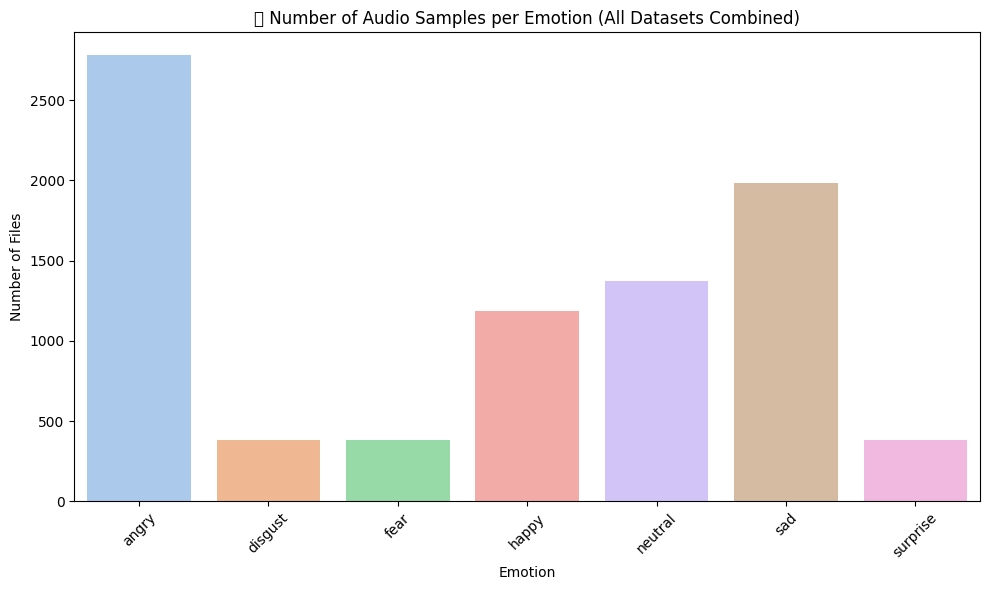

 Data loaded successfully.
 Label mapping complete.
Class distribution: Counter({np.str_('angry'): 3934, np.str_('disgust'): 1893, np.str_('sad'): 1491, np.str_('fear'): 1369, np.str_('surprise'): 434, np.str_('neutral'): 302, np.str_('happy'): 192})
Feature shape before enhancement: (9615, 40)
Feature shape after enhancement: (9615, 3, 40)
 Labels encoded successfully.
 SMOTE oversampling completed.
 Data split into training and test sets.
 Feature scaling applied.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3, 256)              │          51,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 3, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 3, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 679,431 (2.59 MB)

 Trainable params: 678,151 (2.59 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Model compiled successfully.
Epoch 1/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.3091 - auc: 0.6823 - loss: 5.6049 - precision: 0.3516 - recall: 0.2160 - val_accuracy: 0.1848 - val_auc: 0.6159 - val_loss: 5.2586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 9.7977e-05
Epoch 2/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4970 - auc: 0.8364 - loss: 4.7265 - precision: 0.5560 - recall: 0.4136 - val_accuracy: 0.4252 - val_auc: 0.7856 - val_loss: 4.5472 - val_precision: 0.8378 - val_recall: 0.1950 - learning_rate: 9.5994e-05
Epoch 3/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5339 - auc: 0.8614 - loss: 4.3740 - precision: 0.6005 - recall: 0.4465 - val_accuracy: 0.6057 - val_auc: 0.9077 - val_loss: 3.8907 - val_precision: 0.7683 - val_recall: 0.4419 - learning_rate: 9.4052e-05
Epoch 4/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5630 - auc: 0.8788 - loss: 4.0641 - precision: 0.6354 - recall: 0.4717 - val_

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import sys

# 🔁 Label Mapping Function
def map_labels(label):import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Emotion keyword mapping
mapping = {
    'neutral': ['02', 'calm', '01', 'neutral'],
    'happy': ['03', 'happy'],
    'sad': ['04', 'sad', 'sadness', 'sa'],
    'angry': ['05', 'angry', 'anger', 'a'],
    'fear': ['06', 'fear', 'fearful', 'f'],
    'disgust': ['07', 'disgust', 'disgusted', 'd'],
    'surprise': ['08', 'surprised', 'surprise', 'ps', 'pleasant', 'su', 'h']
}

# ✅ Correct dataset paths (copied to /content/datasets)
paths = {
    'CREMA-D': "/content/datasets/cremad",
    'RAVDESS': "/content/datasets/ravdess",
    'SAVEE': "/content/datasets/savee",
    'TESS': "/content/datasets/tess"
}

emotion_counts = defaultdict(int)

# --- 1. CREMA-D ---
# Format: "1016_IEO_HAP_XX.wav" → emotion is 3rd part
crema_path = paths['CREMA-D']
for file in os.listdir(crema_path):
    if file.endswith('.wav'):
        emotion_code = file.split('_')[2].lower()
        for emotion, tags in mapping.items():
            if emotion_code in tags:
                emotion_counts[emotion] += 1
                break

# --- 2. RAVDESS ---
# Format: "03-01-05-01-01-01-01.wav" → third part (index 2) is emotion ID
ravdess_path = paths['RAVDESS']
for root, _, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith('.wav') and '-' in file:
            parts = file.split('-')
            if len(parts) > 2:
                emotion_id = parts[2]
                for emotion, tags in mapping.items():
                    if emotion_id in tags:
                        emotion_counts[emotion] += 1
                        break

# --- 3. SAVEE ---
# Format: "DC_ang.wav" → "ang" before .wav is emotion
savee_path = paths['SAVEE']
for file in os.listdir(savee_path):
    if file.endswith('.wav'):
        emotion_code = file.split('_')[-1].replace('.wav', '').lower()
        for emotion, tags in mapping.items():
            if emotion_code in tags:
                emotion_counts[emotion] += 1
                break

# --- 4. TESS ---
# Folders are emotion names (e.g., “Angry”, “Happy”)
tess_path = paths['TESS']
for root, _, files in os.walk(tess_path):
    for file in files:
        if file.endswith('.wav'):
            folder_name = os.path.basename(root).lower()
            for emotion, tags in mapping.items():
                if any(tag in folder_name for tag in tags):
                    emotion_counts[emotion] += 1
                    break

# --- Plotting ---
emotion_counts_sorted = dict(sorted(emotion_counts.items(), key=lambda x: x[0]))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_counts_sorted.keys()), y=list(emotion_counts_sorted.values()), palette='pastel')
plt.title("🧠 Number of Audio Samples per Emotion (All Datasets Combined)")
plt.ylabel("Number of Files")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 🔁 Label Mapping Function
def map_labels(label):
    label = str(label).lower().strip()
    mapping = {
        'neutral': ['02', 'calm', '01', 'neutral'],
        'happy': ['03', 'happy'],
        'sad': ['04', 'sad', 'sadness', 'sa'],
        'angry': ['05', 'angry', 'anger', 'a'],
        'fear': ['06', 'fear', 'fearful', 'f'],
        'disgust': ['07', 'disgust', 'disgusted', 'd'],
        'surprise': ['08', 'surprised', 'surprise', 'ps', 'pleasant', 'su', 'h']
    }
    for key, values in mapping.items():
        if any(v in label for v in values):
            return key
    return 'unknown'

#  Load Data
try:
    X = np.load("/content/features.npy")
    y = np.load("/content/labels.npy", allow_pickle=True)
    print(" Data loaded successfully.")
except Exception as e:
    print(f" Failed to load features/labels: {e}")
    sys.exit(1)

#  Apply Label Mapping
try:
    y = np.array([map_labels(label) for label in y])
    valid_emotions = {'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'}
    mask = np.isin(y, list(valid_emotions))
    X = X[mask]
    y = y[mask]
    print(" Label mapping complete.")
    print("Class distribution:", Counter(y))
except Exception as e:
    print(f" Error during label processing: {e}")
    sys.exit(1)

#  Feature Engineering
def enhance_features(X):
    try:
        if X.shape[1] < 3:
            print(" Skipping feature enhancement due to short sequence length.")
            return X
        delta = np.diff(X, axis=1)
        delta = np.pad(delta, ((0, 0), (1, 0)), mode='edge')
        delta2 = np.diff(delta, axis=1)
        delta2 = np.pad(delta2, ((0, 0), (1, 0)), mode='edge')
        return np.stack([X, delta, delta2], axis=1)  # Shape: (N, 3, T)
    except Exception as e:
        print(f" Error in feature enhancement: {e}")
        sys.exit(1)

print("Feature shape before enhancement:", X.shape)
X = enhance_features(X)
print("Feature shape after enhancement:", X.shape)

#  Encode Labels
try:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_cat = to_categorical(y_encoded)
    num_classes = len(le.classes_)
    print(" Labels encoded successfully.")
except Exception as e:
    print(f" Error in label encoding: {e}")
    sys.exit(1)

#  SMOTE
try:
    smote = SMOTE(random_state=42)
    X_flat = X.reshape((X.shape[0], -1))
    X_resampled, y_resampled = smote.fit_resample(X_flat, y_encoded)
    X = X_resampled.reshape(-1, 3, 40)
    y_cat = to_categorical(y_resampled, num_classes=num_classes)
    print(" SMOTE oversampling completed.")
except Exception as e:
    print(f" Error during SMOTE: {e}")
    sys.exit(1)

#  Train-Test Split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=0.1, stratify=y_resampled, random_state=42
    )
    print(" Data split into training and test sets.")
except Exception as e:
    print(f" Error in train-test split: {e}")
    sys.exit(1)

#  Standardize Features
try:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    print(" Feature scaling applied.")
except Exception as e:
    print(f" Error in feature scaling: {e}")
    sys.exit(1)

#  Define Model
def build_model(input_shape, num_classes):
    try:
        inputs = layers.Input(shape=input_shape)

        x = layers.Conv1D(256, 5, padding='same', activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.AveragePooling1D(pool_size=1)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

        # Removed attention (not useful for only 3 time steps)
        x = layers.GlobalAveragePooling1D()(x)

        x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        outputs = layers.Dense(num_classes, activation='softmax')(x)

        model = models.Model(inputs, outputs)
        return model
    except Exception as e:
        print(f" Error building model: {e}")
        sys.exit(1)


model = build_model(X_train.shape[1:], num_classes)
model.summary()

#  Optimizer, Loss & Compile
try:
    lr_schedule = schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
    class_weights_dict = dict(enumerate(class_weights))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    print(" Model compiled successfully.")
except Exception as e:
    print(f" Error in optimizer/loss setup: {e}")
    sys.exit(1)

#  Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_auc', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

#  Train
try:
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200,
        batch_size=128,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )
    print(" Model training complete.")
except Exception as e:
    print(f" Error during training: {e}")
    sys.exit(1)

#  Evaluate
try:
    results = model.evaluate(X_test, y_test)
    print(f"""
📊 Final Evaluation:
 Accuracy: {results[1]*100:.2f}%
 Precision: {results[2]*100:.2f}%
 Recall: {results[3]*100:.2f}%
 AUC: {results[4]*100:.2f}%
""")
except Exception as e:
    print(f" Error during evaluation: {e}")

#  Save
try:
    model.save("emotion_recognition_model.keras")
    np.save("scaler_params.npy", {'mean': scaler.mean_, 'scale': scaler.scale_})
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(le, f)
    print(" Model and encoders saved.")
except Exception as e:
    print(f" Error saving model/scaler/label encoder: {e}")


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


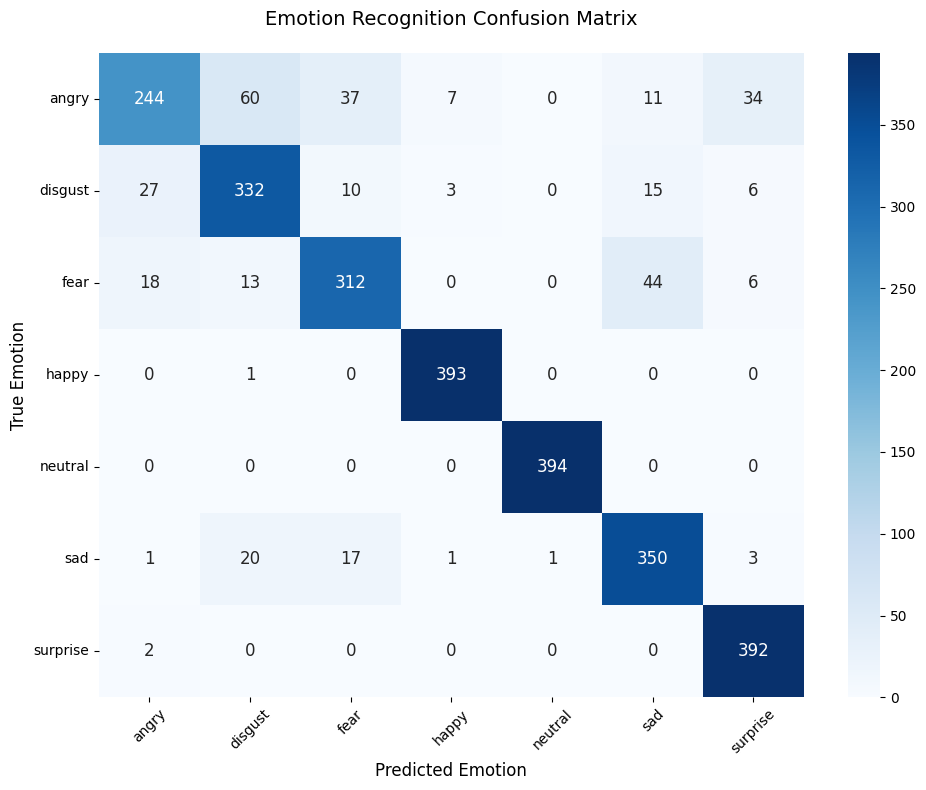


Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.62      0.71       393
     disgust       0.78      0.84      0.81       393
        fear       0.83      0.79      0.81       393
       happy       0.97      1.00      0.98       394
     neutral       1.00      1.00      1.00       394
         sad       0.83      0.89      0.86       393
    surprise       0.89      0.99      0.94       394

    accuracy                           0.88      2754
   macro avg       0.88      0.88      0.87      2754
weighted avg       0.88      0.88      0.87      2754



In [7]:
# Generate Confusion Matrix for Test Data
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot_kws={'size': 12})
plt.title('Emotion Recognition Confusion Matrix', pad=20, fontsize=14)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))